In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [2]:
!wget --no-check-certificate -nc 'https://docs.google.com/uc?export=download&id=1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_' -O spam.csv

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

--2022-04-23 16:37:16--  https://docs.google.com/uc?export=download&id=1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_
Resolving docs.google.com (docs.google.com)... 142.251.12.113, 142.251.12.101, 142.251.12.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m8073chs7bisjlf1e1ei6rlla33mmh90/1650731775000/08702983968081230261/*/1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_?e=download [following]
--2022-04-23 16:37:16--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m8073chs7bisjlf1e1ei6rlla33mmh90/1650731775000/08702983968081230261/*/1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.goog

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# rename columns to something better
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [6]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [7]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7168 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train :', data_train.shape)

Shape of data train : (3733, 189)


In [10]:
# get sequence length
T = data_train.shape[1]

In [11]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test:', data_test.shape)

Shape of data test: (1839, 189)


In [12]:
# Create the model

# Hyperparameter: Embedding Dimensionality
D = 20

# Hyperparameter: Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)          #embedding dim set to 20 (not power of 2) +1 - the first word index starts with 1
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [13]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 [==============================] - 10s 16ms/step - loss: 0.4795 - accuracy: 0.8661 - val_loss: 0.3938 - val_accuracy: 0.8657
Epoch 2/10
117/117 [==============================] - 1s 11ms/step - loss: 0.3913 - accuracy: 0.8661 - val_loss: 0.3882 - val_accuracy: 0.8657
Epoch 3/10
117/117 [==============================] - 1s 12ms/step - loss: 0.3661 - accuracy: 0.8661 - val_loss: 0.3408 - val_accuracy: 0.8657
Epoch 4/10
117/117 [==============================] - 1s 11ms/step - loss: 0.2659 - accuracy: 0.8661 - val_loss: 0.2224 - val_accuracy: 0.8657
Epoch 5/10
117/117 [==============================] - 1s 11ms/step - loss: 0.1685 - accuracy: 0.9365 - val_loss: 0.1539 - val_accuracy: 0.9690
Epoch 6/10
117/117 [==============================] - 1s 11ms/step - loss: 0.1039 - accuracy: 0.9887 - val_loss: 0.1056 - val_accuracy: 0.9761
Epoch 7/10
117/117 [==============================] - 1s 11ms/step - loss: 0.0600 - accuracy: 0.9928 - val_loss: 0.0867 - v

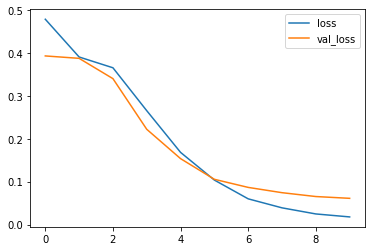

In [14]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

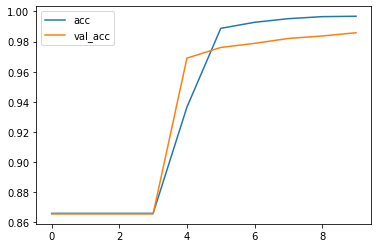

In [15]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()